# ADIA Lab Structural Break Open Benchmark Challenge

## Problem Description
Participants are asked to build models that determine whether a structural break has occurred at a known breakpoint in a univariate time series.
A structural break corresponds to a change in the underlying data generating process. Such breaks are common in economic and financial time series and can significantly impact inference, forecasting, and decision making.
Each time series consists of two segments separated by a known boundary. The task is to assess whether the statistical properties of the two segments differ in a way consistent with a structural break.

## Dataset Description

The dataset consists of a large collection of **synthetic univariate time series** designed for **structural break detection**. Each time series contains a predefined boundary point at which a structural break may or may not occur.

The training set includes **10,000 time series**, with an additional **10,000 series** for both the public and private test sets. For local evaluation, a smaller test set of **100 time series** is provided. Each series contains approximately **1,000–5,000 observations**.

The input data are stored as a `pandas.DataFrame` with a **MultiIndex** structure `(id, time)`, and include the following columns:

- **value**: the observed time series value at each timestep  
- **period**: a binary indicator, where `0` denotes observations before the boundary point and `1` denotes observations after the boundary point  

The target variable `y` is a boolean `pandas.Series` indexed by **id**, indicating whether a structural break occurs at the boundary point (`True` for break, `False` otherwise).

Models must be **computationally efficient and deterministic**. A determinism check re-runs inference on **30% of the test data**, requiring identical outputs within a tolerance of **1e−8**.


### Import Custom Functions

All custom utility functions and model pipelines are imported from `function.py`, including feature generation, visualization routines, and model training components used in the subsequent analysis.

In [1]:
# import function
from function import *

D:\Anaconda\envs\tab_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

The training and test datasets are loaded from parquet files.  
The input data are organized in a long-format `DataFrame` with a MultiIndex `(id, time)`, while the corresponding labels indicate whether a structural break occurs at the predefined boundary point for each time series.

In [2]:
X_train = pd.read_parquet("../data/X_train.parquet")
y_train = pd.read_parquet("../data/y_train.parquet")
X_test  = pd.read_parquet("../data/X_test.reduced.parquet")
y_test  = pd.read_parquet("../data/y_test.reduced.parquet")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23715734, 2) (10001, 1) (233802, 2) (101, 1)


### Visualization of a True Structural Break

This visualization explores a time series identified with a true structural break (target_id=10000). The `plot_true_breakpoint_transformations` function generates multiple subplots showing the same time series under different deterministic transformations:

1. **Original Series**: Raw time series values over time
2. **Normalized**: Standardized values using z-score normalization
3. **Cumulative Sum**: Running total to highlight trend changes
4. **Rank Transform**: Values replaced by their rank order
5. **Dense Rank**: Map values to their dense rank order to retain relative ordering and suppress magnitude effects
6. **Rolling Mean**: Smoothed values using a moving window average
7. **Rolling Std**: Rolling standard deviation to detect volatility changes

The vertical dashed line marks the predefined boundary point where the structural break occurs. These transformations help visualize how the statistical properties change before and after the break, making the structural change more apparent through different lenses of analysis.

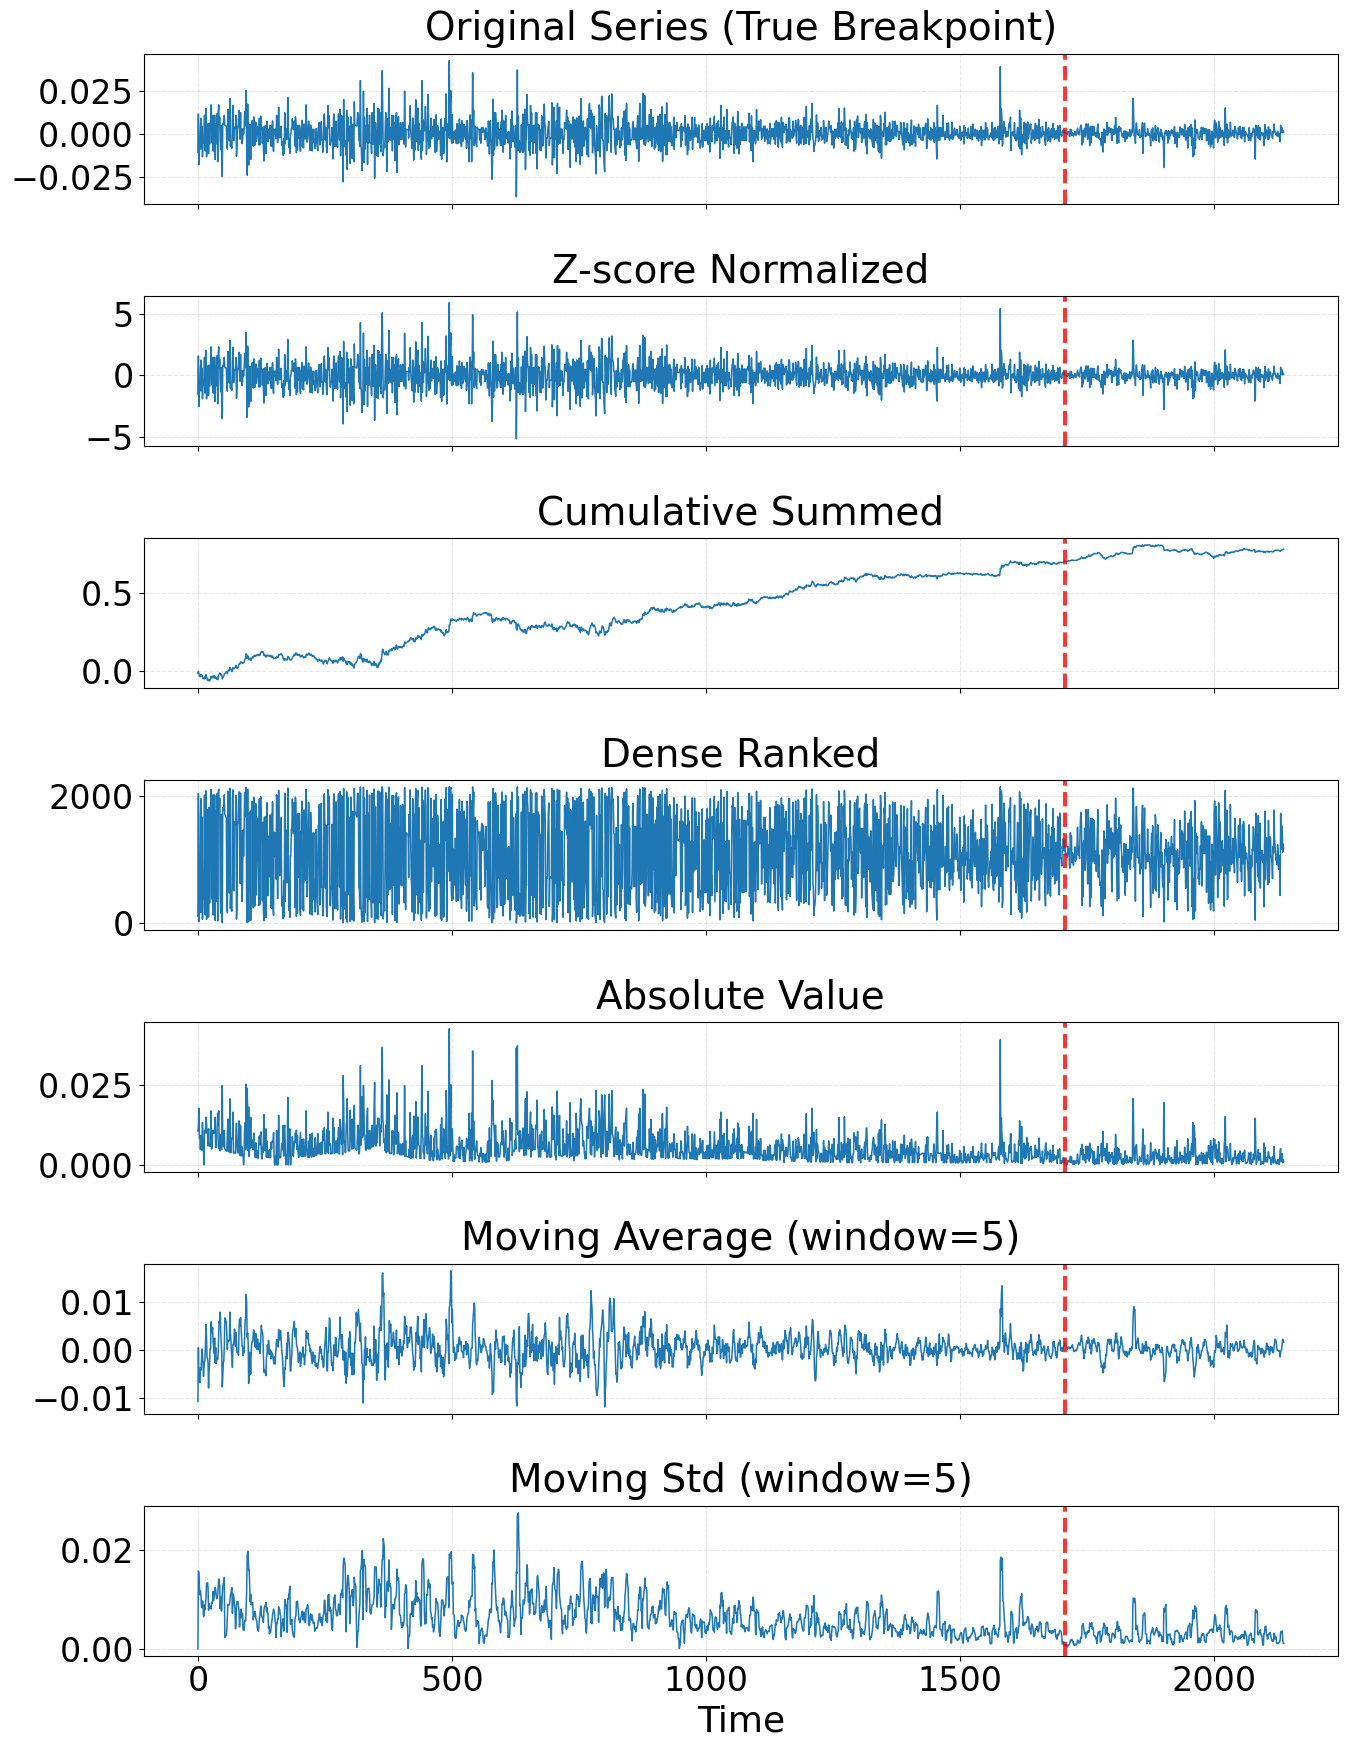

Saved figure to: ..\picture\true_breakpoint_transformations.png and ..\picture\true_breakpoint_transformations.pdf


In [3]:
png_path, pdf_path = plot_true_breakpoint_transformations(
    X_train=X_train,
    y_train=y_train,
    target_id=10000,
    moving_window=5,
    label_col="structural_breakpoint",
    save_stem="true_breakpoint_transformations",
    dpi=450,
)
print(f"Saved figure to: {png_path} and {pdf_path}")

Using the `plot_8_tests_train_roc_4x2` function to evaluate eight classical statistical tests on the training dataset. This function generates a 4×2 grid of ROC curves, with each subplot showing the performance of one statistical test:

- **T-Test**: Compares means between the two time periods
- **Mann-Whitney U Test**: Non-parametric test for distribution differences
- **Levene's Test**: Tests for equality of variances
- **Kolmogorov-Smirnov Test**: Compares empirical distributions
- **Variance Ratio Test**: Compares variance magnitudes between periods
- **CUSUM Test**: Detects cumulative deviations from expected values
- **Autocorrelation Test**: Examines changes in temporal dependencies
- **Runs Test**: Tests for randomness in the sequence

Each ROC curve displays the True Positive Rate against False Positive Rate, with AUC scores indicating discriminative power. The diagonal dashed line represents random chance (AUC=0.5). Higher AUC values indicate better ability to distinguish between time series with and without structural breaks.

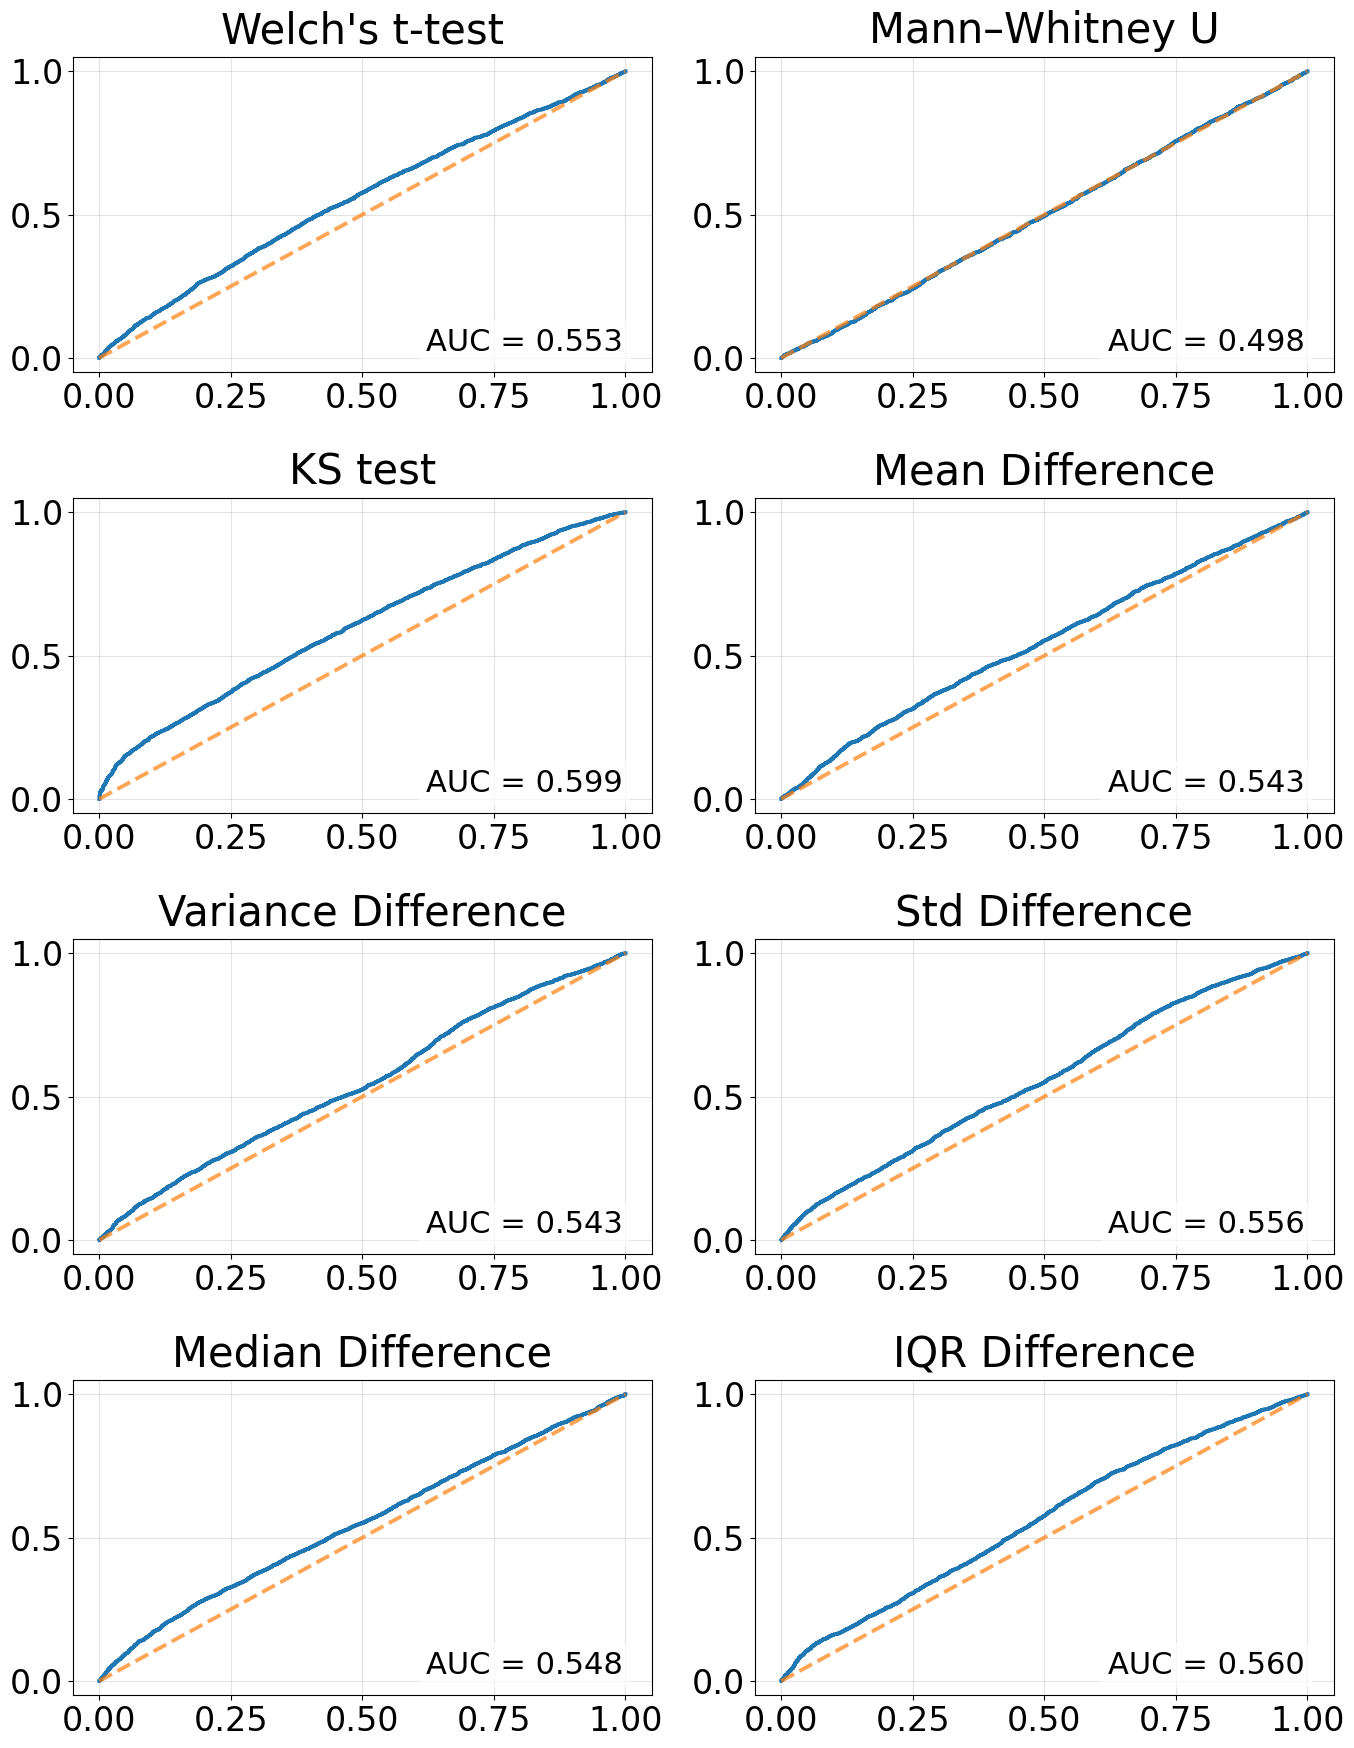

Saved figure to: ..\picture\statistical_tests_train_roc_4x2.png and ..\picture\statistical_tests_train_roc_4x2.pdf


In [4]:
png_path, pdf_path = plot_8_tests_train_roc_4x2(
    X_train=X_train,
    y_train=y_train,
    save_stem="statistical_tests_train_roc_4x2",
    dpi=450,
    label_col="structural_breakpoint",
)

print(f"Saved figure to: {png_path} and {pdf_path}")

Running comprehensive machine learning model comparison using the `run_compare_models_train_oof_and_test` function. This pipeline performs the following steps:

1. **Feature Engineering**: Extracts statistical features from the raw time series data:
   - Summary statistics for each period (mean, median, std, min, max, skewness, kurtosis)
   - Distributional metrics (quantiles, IQR, coefficient of variation)
   - Statistical test p-values as features
   - Difference metrics between the two periods (mean difference, variance ratio, etc.)

2. **10-Fold Cross-Validation**: Implements stratified K-fold cross-validation on the training set to generate Out-of-Fold (OOF) predictions, ensuring unbiased performance estimates and preventing overfitting.

3. **Multiple Classifiers**: Trains and evaluates seven machine learning models:
   - **Logistic Regression**: Linear baseline model with L2 regularization
   - **Decision Tree**: Single decision tree classifier as a baseline
   - **Random Forest**: Ensemble of decision trees with bootstrap aggregating
   - **Extra Trees**: Extremely randomized trees with random thresholds
   - **XGBoost**: Gradient boosting with tree-based learners and advanced regularization
   - **LightGBM**: Gradient boosting using histogram-based learning for faster training
   - **CatBoost**: Gradient boosting with built-in handling of categorical features and ordered boosting

4. **Performance Visualization**: Generates side-by-side ROC curve plots comparing all models on both:
   - Training set (using OOF predictions)
   - Test set (using held-out data)

The function outputs feature matrices (`X_train_feat`, `X_test_feat`) for further modeling and saves publication-quality figures (PNG and PDF) showing comparative model performance. Each model's AUC score is displayed in the legend for easy comparison.


LogisticRegression
SVM-RBF
RandomForest
GradientBoosting
LightGBM
XGBoost
CatBoost


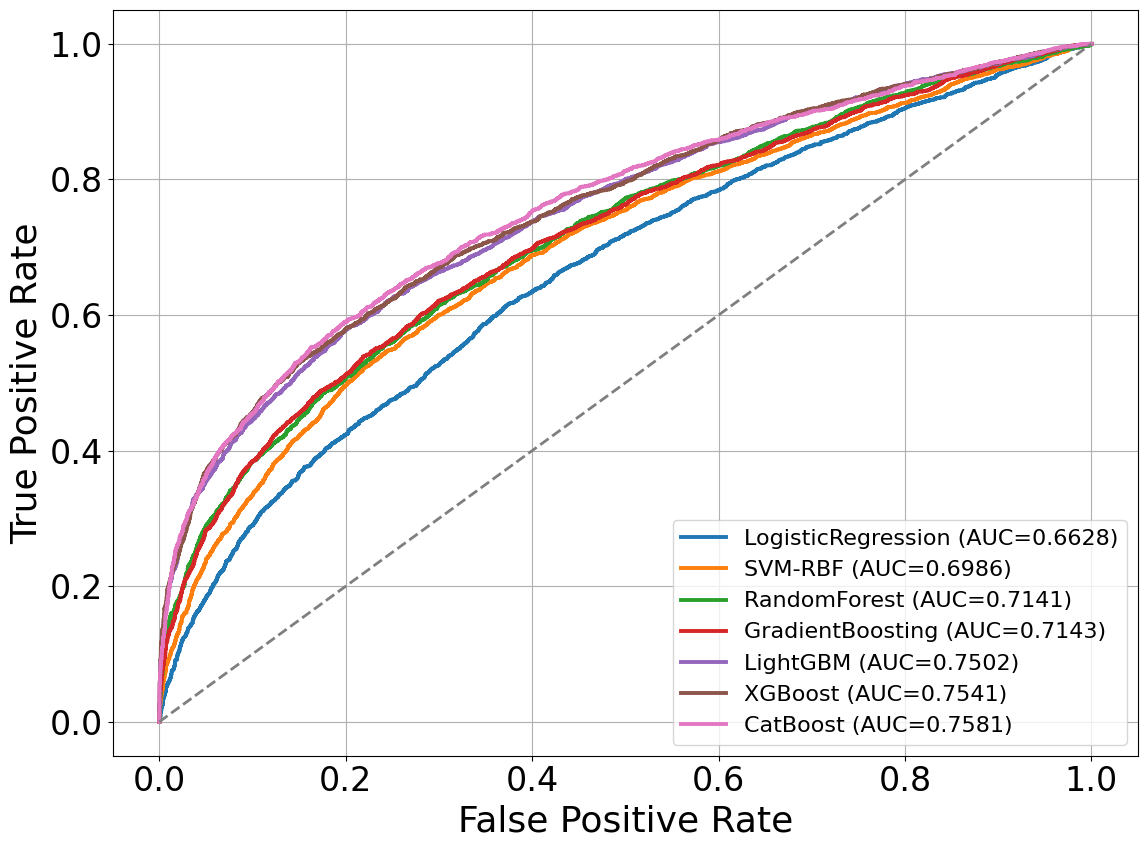

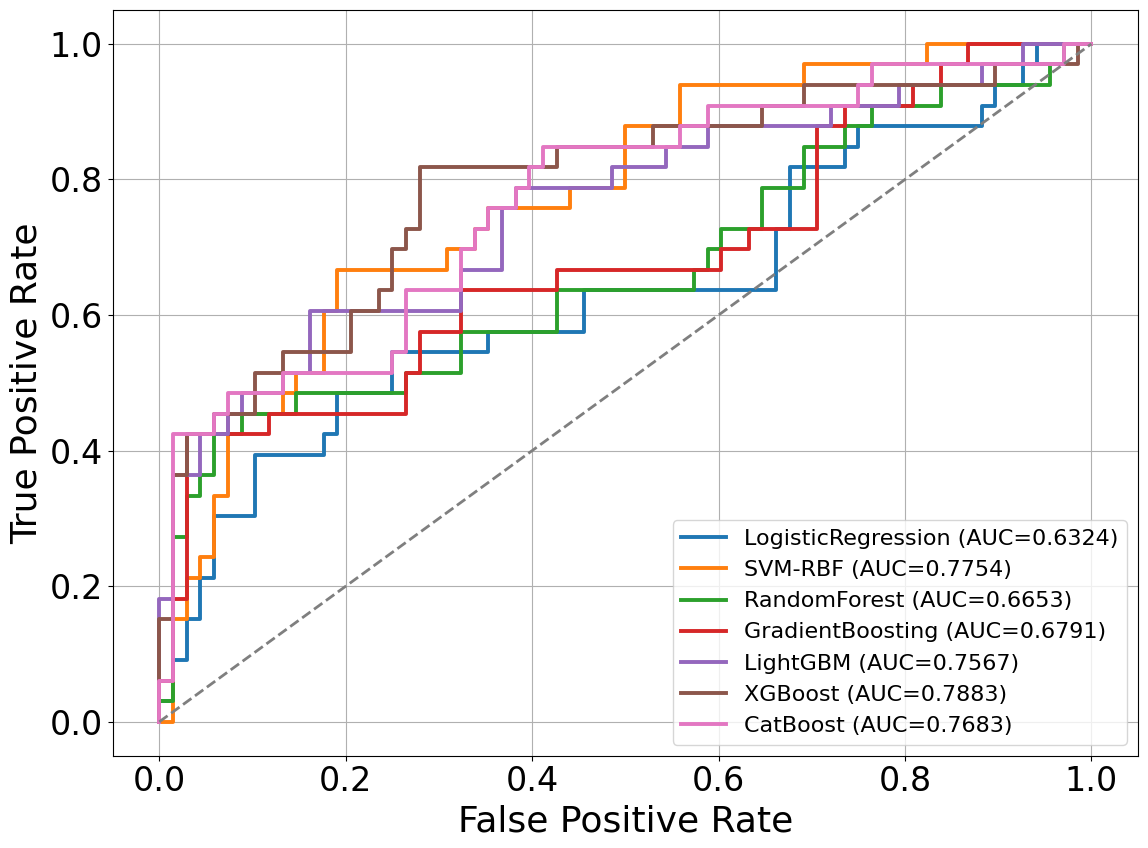

Used models: ['LogisticRegression', 'SVM-RBF', 'RandomForest', 'GradientBoosting', 'LightGBM', 'XGBoost', 'CatBoost']
Train ROC PNG: ..\picture\roc_train_oof.png
Train ROC PDF: ..\picture\roc_train_oof.pdf
Test  ROC PNG: ..\picture\roc_test.png
Test  ROC PDF: ..\picture\roc_test.pdf


In [5]:
out_cmp = run_compare_models_train_oof_and_test(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_folds=10,
    seed=42,
    include_tabpfn=False,
    label_col="structural_breakpoint",
    save_train_stem="roc_train_oof",
    save_test_stem="roc_test",
    dpi=450,
)

print("Used models:", out_cmp["used_models"])
print("Train ROC PNG:", out_cmp["train_roc_png"])
print("Train ROC PDF:", out_cmp["train_roc_pdf"])
print("Test  ROC PNG:", out_cmp["test_roc_png"])
print("Test  ROC PDF:", out_cmp["test_roc_pdf"])

X_train_feat = out_cmp["X_train_feat"]
X_test_feat = out_cmp["X_test_feat"]

Implementing an advanced meta-learning ensemble using the `run_tabpfn_x1_plus_s234_three_models` function. This approach combines TabPFN (Tabular Prior-Fitted Networks) with three gradient boosting models in a two-stage architecture:

**Stage 1: TabPFN Base Model**
- **TabPFN** is a transformer-based model pre-trained on millions of synthetic tabular datasets
- Uses in-context learning (similar to GPT for tabular data) without requiring gradient updates
- Processes the engineered features and generates probabilistic predictions
- Particularly effective for small-to-medium datasets (up to 10,000 samples)

**Stage 2: Gradient Boosting Meta-Models**
Three gradient boosting algorithms are trained on an augmented feature set:
- **Original Features (X1)**: The statistical features extracted in the previous step
- **TabPFN Predictions (S2, S3, S4)**: Prediction probabilities from TabPFN serve as powerful meta-features

The three boosting models:
- **XGBoost**: Uses gradient-based optimization with tree pruning and regularization
- **LightGBM**: Employs leaf-wise tree growth and histogram-based splits for efficiency
- **CatBoost**: Implements ordered boosting and built-in categorical encoding

**Cross-Validation and Model Saving:**
- 10-fold cross-validation ensures robust Out-of-Fold predictions
- ROC curves compare the three meta-models on both training and test sets
- The `save_pipelines_from_run_output` function serializes all trained models to the `models_tabpfn_plus_boost/` directory as pickle files for deployment

This stacking approach leverages the pattern recognition power of transformers with the interpretability and robustness of tree-based models.

[TabPFN OOF] start | folds=10 | n=10001
[TabPFN OOF] fold 01/10 | tr=9000 va=1001 ...
[TabPFN OOF] fold 01/10 done | 7.0 min
[TabPFN OOF] fold 02/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 02/10 done | 6.7 min
[TabPFN OOF] fold 03/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 03/10 done | 7.5 min
[TabPFN OOF] fold 04/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 04/10 done | 7.3 min
[TabPFN OOF] fold 05/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 05/10 done | 7.4 min
[TabPFN OOF] fold 06/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 06/10 done | 7.1 min
[TabPFN OOF] fold 07/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 07/10 done | 7.3 min
[TabPFN OOF] fold 08/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 08/10 done | 6.6 min
[TabPFN OOF] fold 09/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 09/10 done | 7.2 min
[TabPFN OOF] fold 10/10 | tr=9001 va=1000 ...
[TabPFN OOF] fold 10/10 done | 7.0 min
[TabPFN OOF] all done | total=71.0 min


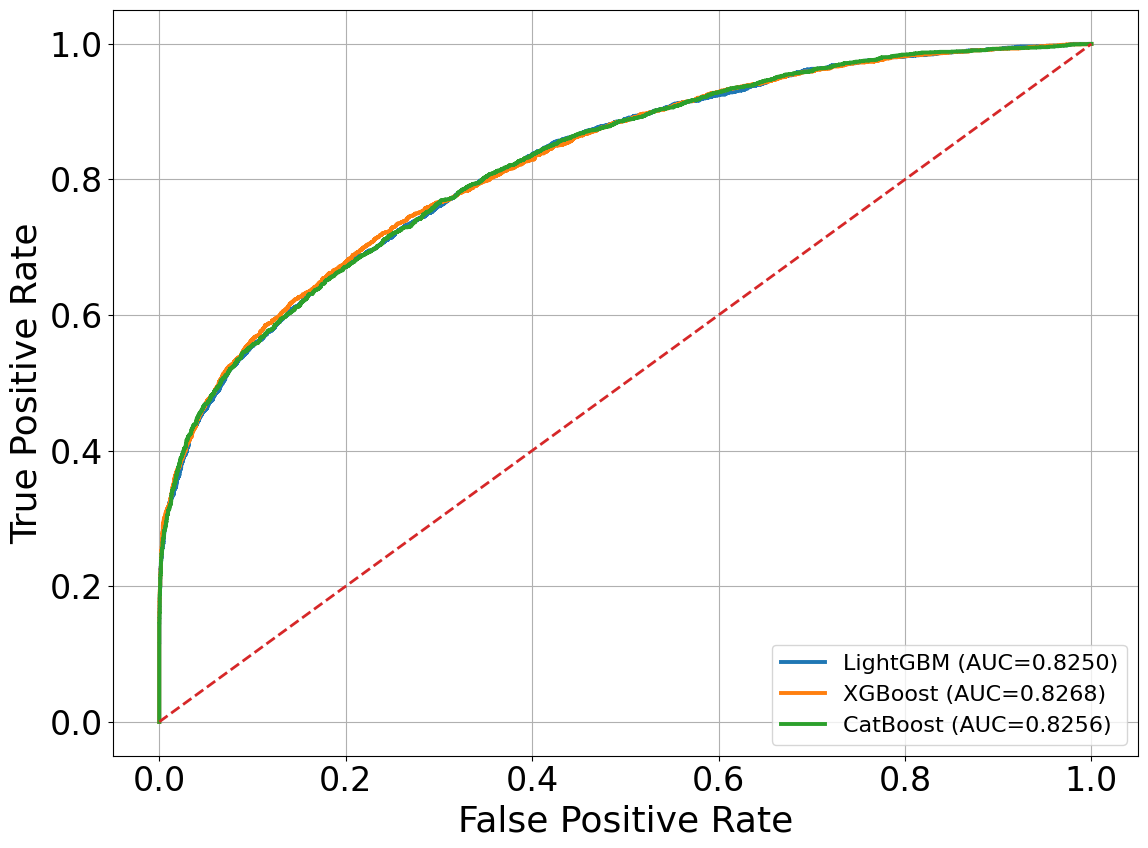

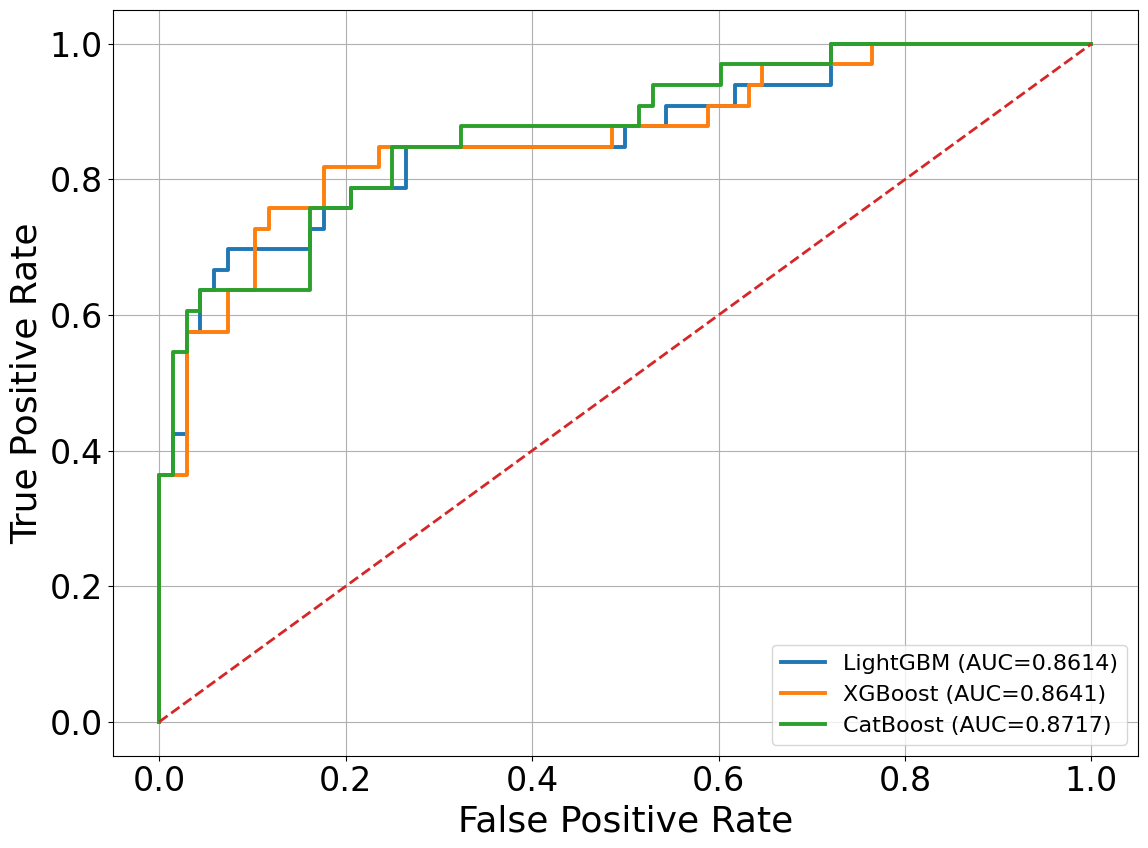

{'LightGBM': 'models_tabpfn_plus_boost\\TabPFN_plus_LightGBM.pkl', 'XGBoost': 'models_tabpfn_plus_boost\\TabPFN_plus_XGBoost.pkl', 'CatBoost': 'models_tabpfn_plus_boost\\TabPFN_plus_CatBoost.pkl'}


In [6]:
out = run_tabpfn_x1_plus_s234_three_models(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_folds=10,
    seed=42,
    dpi=450,
    save_stem_train="roc_train_oof_meta_3boost",
    save_stem_test="roc_test_meta_3boost",
)

saved = save_pipelines_from_run_output(
    out=out,
    X_train=X_train,
    y_train=y_train,
    seed=42,
    save_dir="models_tabpfn_plus_boost",
)

print(saved)

Generating comprehensive model diagnostics and visualizations using the `export_model_figures` function. This final analysis step focuses on the best-performing model (TabPFN + CatBoost) and produces several publication-quality figures:

**Model Loading:**
- Loads the saved CatBoost ensemble model from `models_tabpfn_plus_boost/TabPFN_plus_CatBoost.pkl`
- This model combines TabPFN predictions with CatBoost gradient boosting

**Generated Visualizations:**

1. **ROC Curves (Training vs Test)**:
   - Side-by-side comparison showing model performance on both datasets
   - True Positive Rate vs False Positive Rate with AUC scores
   - Helps assess generalization and detect potential overfitting

2. **Feature Importance Plot**:
   - Horizontal bar chart ranking the top 25 most influential features (`k_features=25`)
   - Shows which statistical properties contribute most to structural break detection
   - Based on CatBoost's built-in feature importance calculation

3. **Prediction Distribution**:
   - Histograms showing predicted probability distributions for positive and negative classes
   - Helps assess model confidence and decision threshold selection

4. **Calibration Curve** (if applicable):
   - Compares predicted probabilities against observed frequencies
   - Evaluates reliability of probability estimates

All figures are saved in high resolution (450 DPI) in both PNG and PDF formats with the filename prefix `TabPFN_plus_CatBoost`. These visualizations provide essential insights into model behavior, interpretability, and reliability for the structural break detection task.

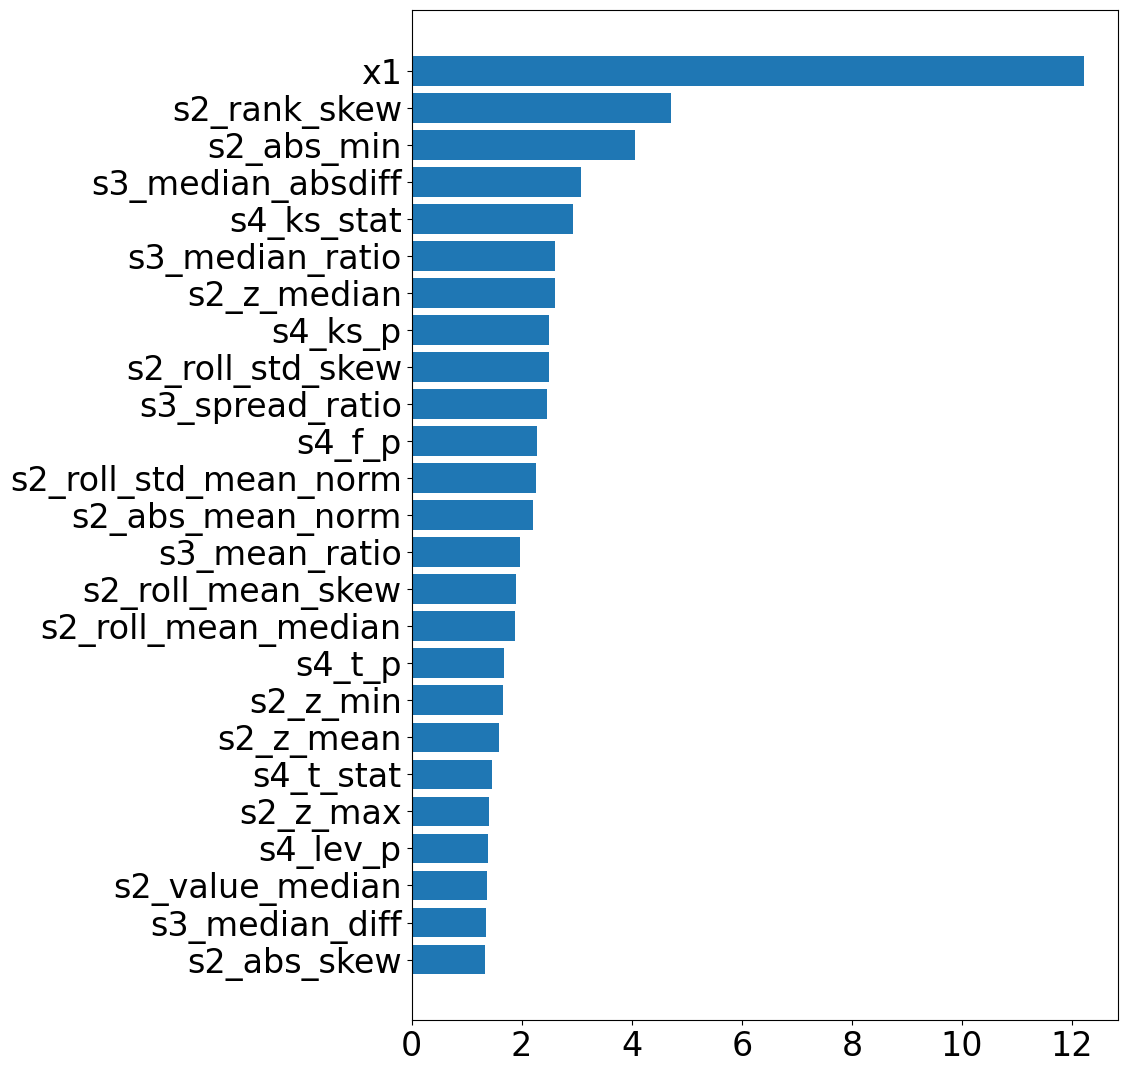

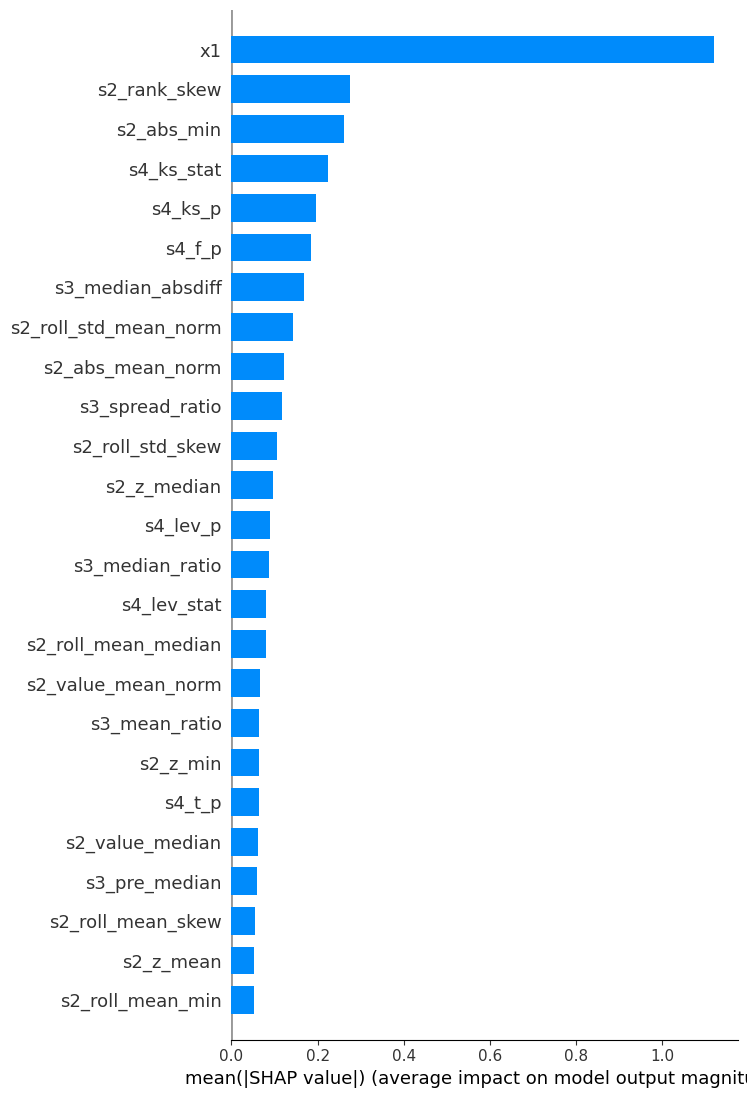

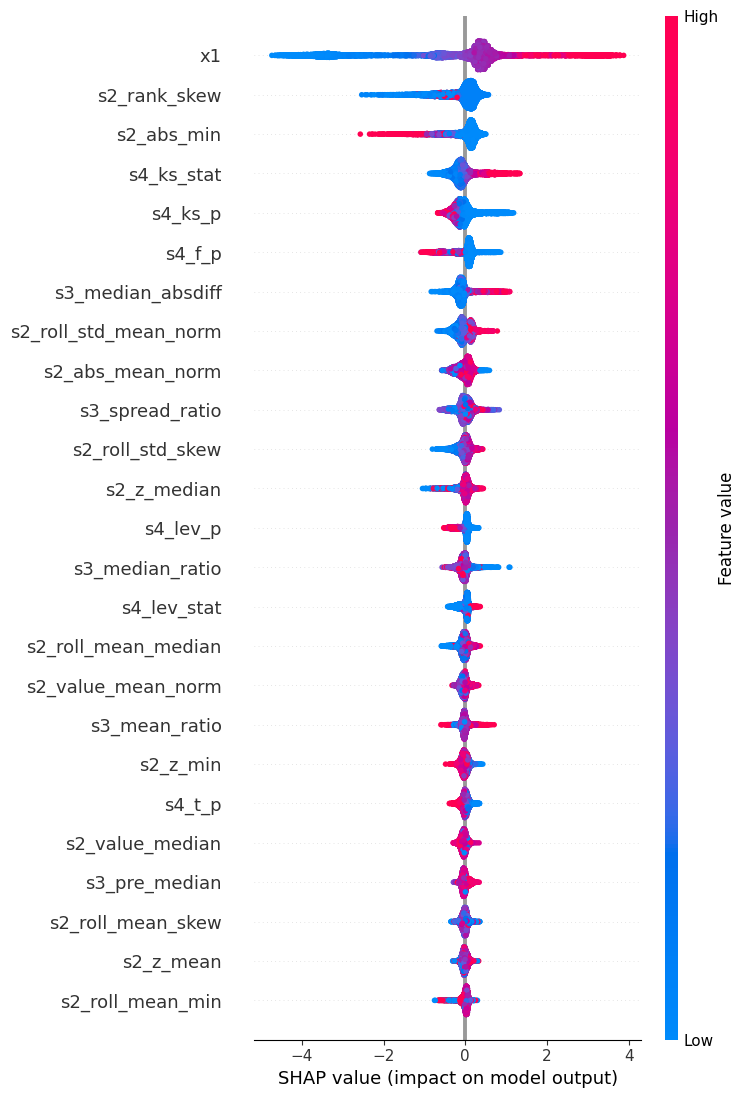

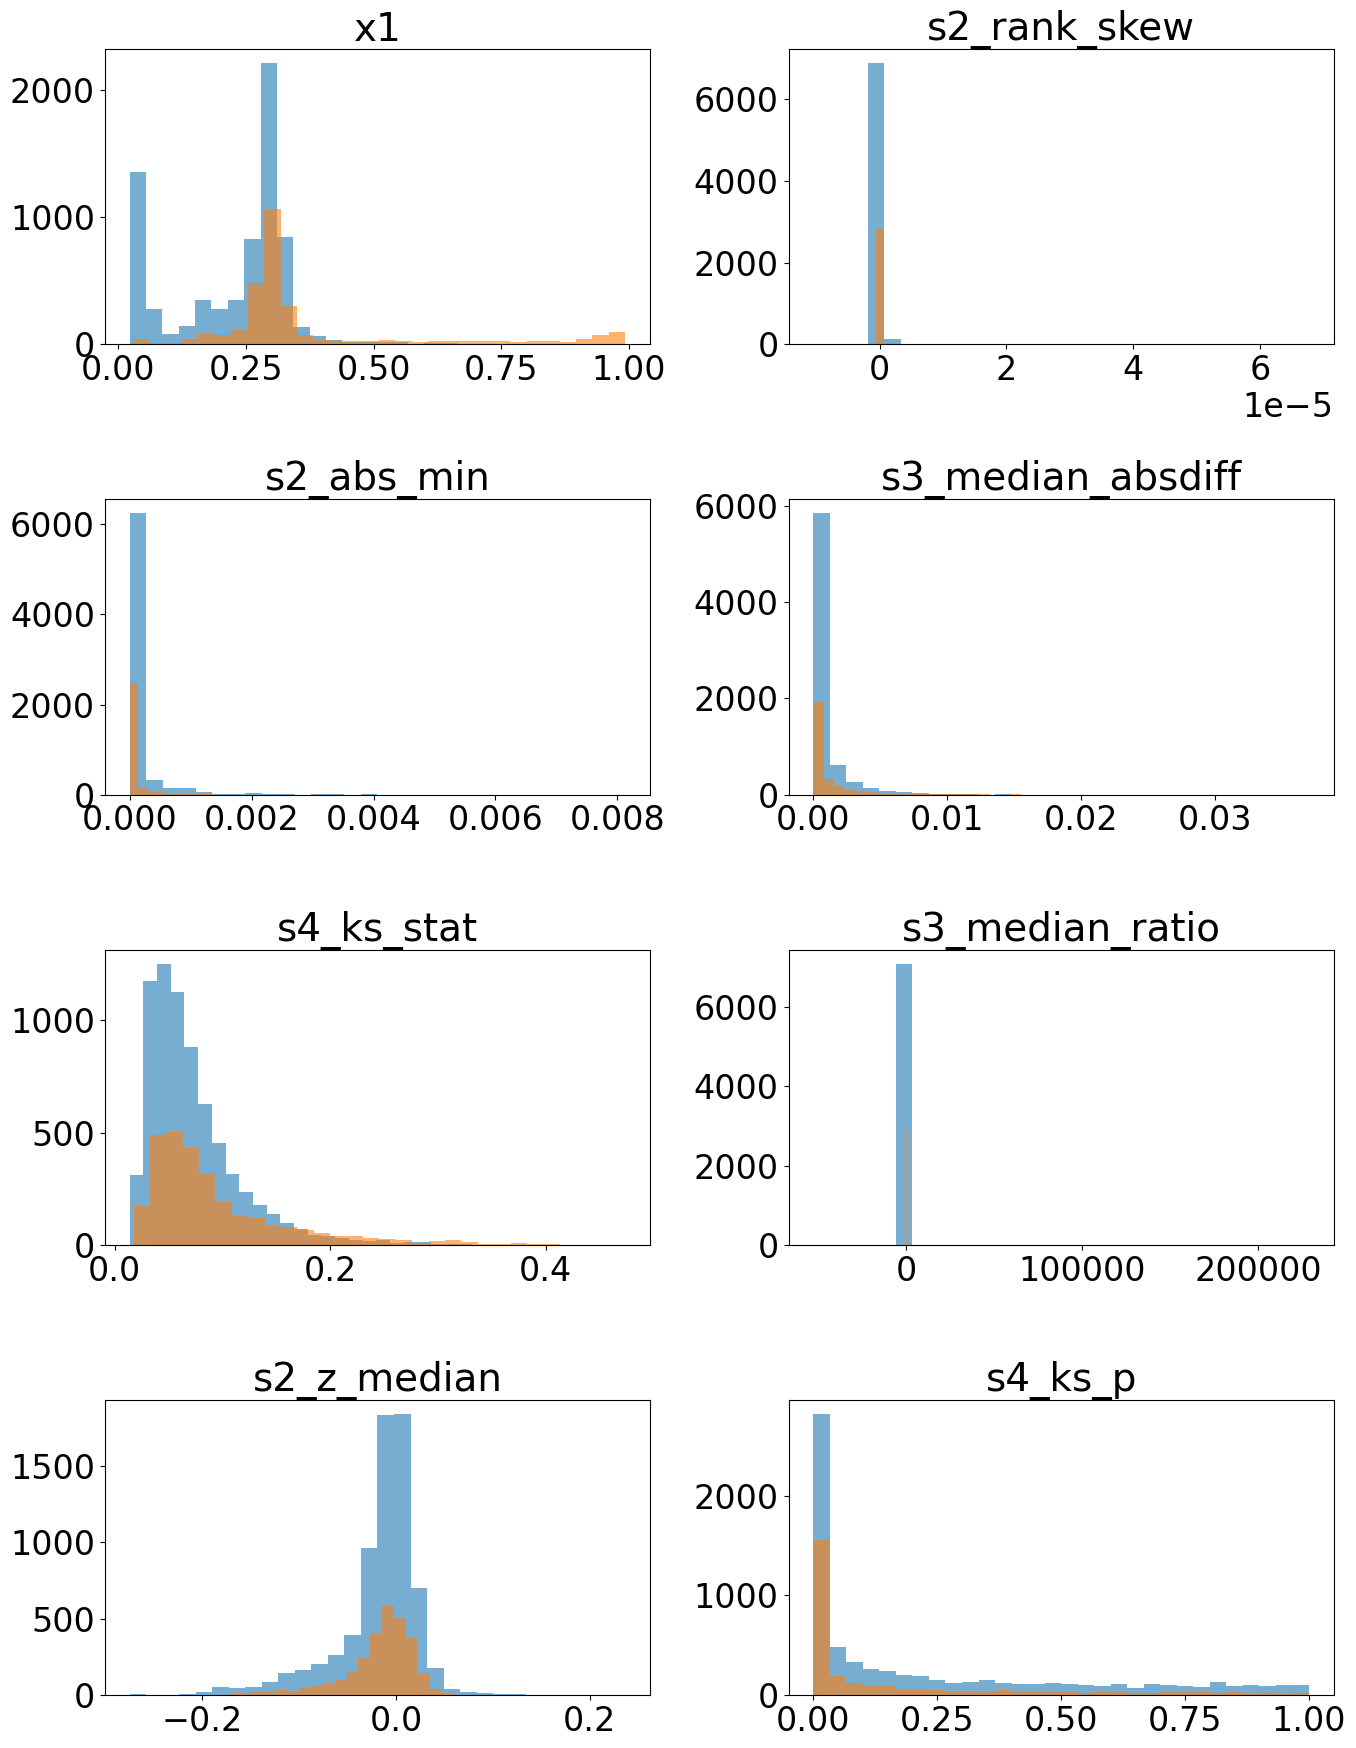

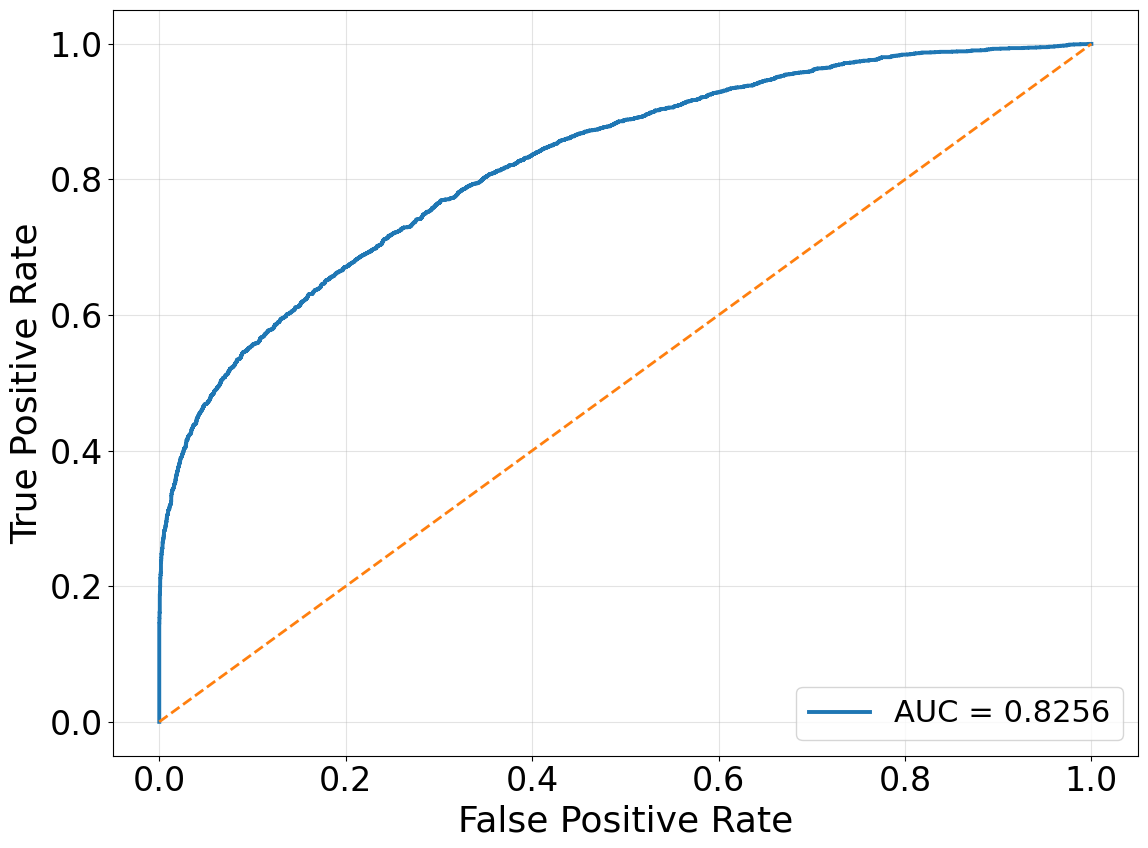

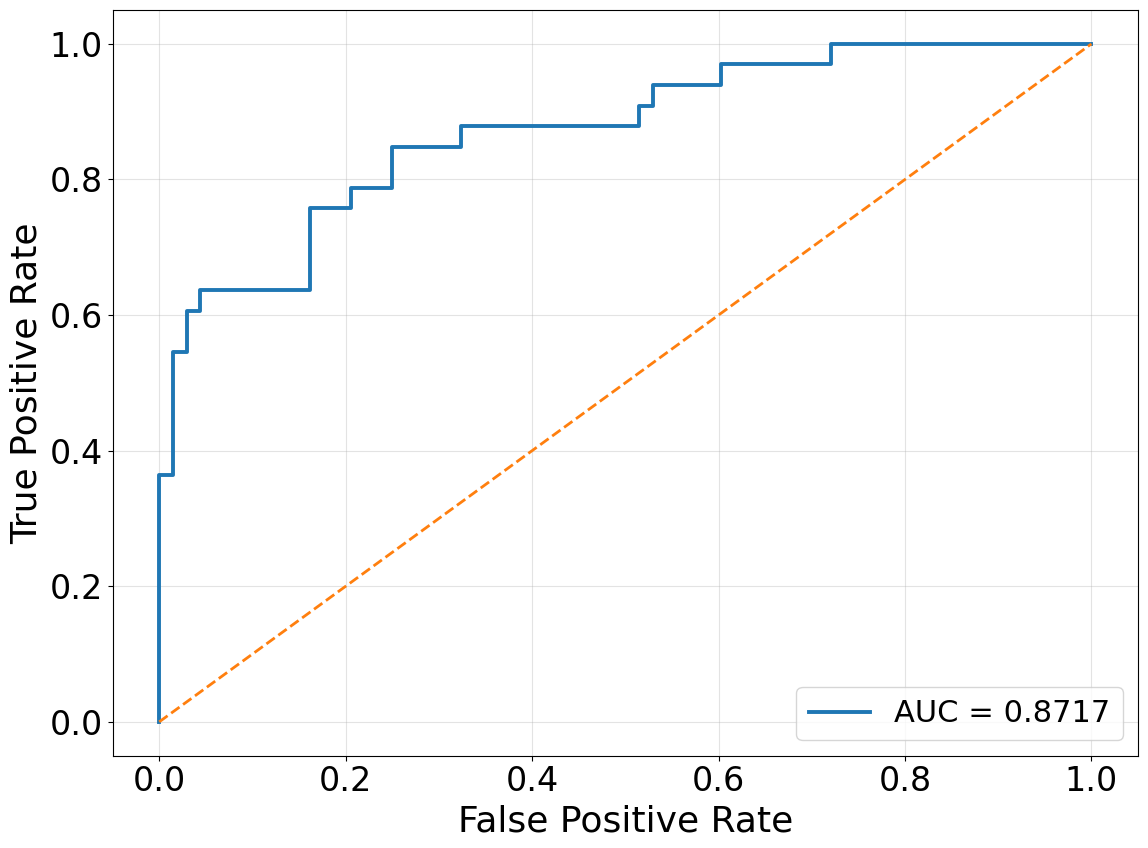

[CatBoost] Train OOF AUC = 0.8256
[CatBoost] Test AUC      = 0.8717


In [8]:
MODEL_PATH = os.path.join("models_tabpfn_plus_boost", "TabPFN_plus_CatBoost.pkl")

export_model_figures(
    out=out,
    model_name="CatBoost",
    model_path=MODEL_PATH,
    stem="TabPFN_plus_CatBoost",
    k_features=25,
)
